# ⭐ Lora Trainer by Hollowstrawberry

This is based on the work of [Kohya-ss](https://github.com/kohya-ss/sd-scripts) and [Linaqruf](https://colab.research.google.com/github/Linaqruf/kohya-trainer/blob/main/kohya-LoRA-dreambooth.ipynb). Thank you!


### ⭕ Disclaimer
The purpose of this document is to research bleeding-edge technologies in the field of machine learning.  
Please read and follow the [Google Colab guidelines](https://research.google.com/colaboratory/faq.html) and its [Terms of Service](https://research.google.com/colaboratory/tos_v3.html).

| |GitHub|🇬🇧 English|🇪🇸 Spanish|
|:--|:-:|:-:|:-:|
| 🏠 **Homepage** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab) | | |
| 📊 **Dataset Maker** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab/blob/main/Dataset_Maker.ipynb) | [![Open in Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Dataset_Maker.ipynb) | [![Abrir en Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge-spanish.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Spanish_Dataset_Maker.ipynb) |
| ⭐ **Lora Trainer** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer.ipynb) | [![Open in Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer.ipynb) | [![Abrir en Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge-spanish.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Spanish_Lora_Trainer.ipynb) |
| 🌟 **XL Lora Trainer** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer_XL.ipynb) | [![Open in Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer_XL.ipynb) |  |
| 🌟 **Legacy XL Trainer** | [![GitHub](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/github.svg)](https://github.com/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer_XL_Legacy.ipynb) | [![Open in Colab](https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/assets/colab-badge.svg)](https://colab.research.google.com/github/hollowstrawberry/kohya-colab/blob/main/Lora_Trainer_XL_Legacy.ipynb) |  |

In [1]:
import os
import re
import toml
from time import time
from IPython.display import Markdown, display

# These carry information from past executions
if "model_url" in globals():
  old_model_url = model_url
else:
  old_model_url = None
if "dependencies_installed" not in globals():
  dependencies_installed = False
if "model_file" not in globals():
  model_file = None

# These may be set by other cells, some are legacy
if "custom_dataset" not in globals():
  custom_dataset = None
if "override_dataset_config_file" not in globals():
  override_dataset_config_file = None
if "override_config_file" not in globals():
  override_config_file = None
if "optimizer" not in globals():
  optimizer = "AdamW8bit"
if "optimizer_args" not in globals():
  optimizer_args = None
if "continue_from_lora" not in globals():
  continue_from_lora = ""
if "weighted_captions" not in globals():
  weighted_captions = False
if "adjust_tags" not in globals():
  adjust_tags = False
if "keep_tokens_weight" not in globals():
  keep_tokens_weight = 1.0

COLAB = True # low ram
XFORMERS = True
SOURCE = "https://github.com/uYouUs/sd-scripts"
COMMIT = None
BETTER_EPOCH_NAMES = True
LOAD_TRUNCATED_IMAGES = True

#@title ## 🚩 Start Here

#@markdown ### ▶️ Setup
#@markdown Your project name will be the same as the folder containing your images. Spaces aren't allowed.
project_name = "sketch_projesi" #@param {type:"string"}
project_name = project_name.strip()
#@markdown The folder structure doesn't matter and is purely for comfort. Make sure to always pick the same one. I like organizing by project.
folder_structure = "Organize by project (MyDrive/Loras/project_name/dataset)" #@param ["Organize by category (MyDrive/lora_training/datasets/project_name)", "Organize by project (MyDrive/Loras/project_name/dataset)"]
#@markdown Decide the model that will be downloaded and used for training. These options should produce clean and consistent results. You can also choose your own by pasting its download link.
training_model = "Stable Diffusion (sd-v1-5-pruned-noema-fp16.safetensors)" #@param ["Anime (animefull-final-pruned-fp16.safetensors)", "AnyLora (AnyLoRA_noVae_fp16-pruned.ckpt)", "Stable Diffusion (sd-v1-5-pruned-noema-fp16.safetensors)"]
optional_custom_training_model_url = "" #@param {type:"string"}
custom_model_is_based_on_sd2 = False #@param {type:"boolean"}

if optional_custom_training_model_url:
  model_url = optional_custom_training_model_url
elif "AnyLora" in training_model:
  model_url = "https://huggingface.co/Lykon/AnyLoRA/resolve/main/AnyLoRA_noVae_fp16-pruned.ckpt"
elif "Anime" in training_model:
  model_url = "https://huggingface.co/hollowstrawberry/stable-diffusion-guide/resolve/main/models/animefull-final-pruned-fp16.safetensors"
else:
  model_url = "https://huggingface.co/hollowstrawberry/stable-diffusion-guide/resolve/main/models/sd-v1-5-pruned-noema-fp16.safetensors"

#@markdown ### ▶️ Processing
#@markdown Resolution of 512 is standard for Stable Diffusion 1.5. Higher resolution training is much slower but can lead to better details. <p>
#@markdown Images will be automatically scaled while training to produce the best results, so you don't need to crop or resize anything yourself.
resolution = 512 #@param {type:"slider", min:512, max:1024, step:128}
#@markdown This option will train your images both normally and flipped, for no extra cost, to learn more from them. Turn it on specially if you have less than 20 images. <p>
#@markdown **Turn it off if you care about asymmetrical elements in your Lora**.
flip_aug = False #@param {type:"boolean"}
#markdown Leave empty for no captions.
caption_extension = ".txt" #param {type:"string"}
#@markdown Shuffling anime tags in place improves learning and prompting. An activation tag goes at the start of every text file and will not be shuffled.
shuffle_tags = True #@param {type:"boolean"}
shuffle_caption = shuffle_tags
activation_tags = "1" #@param [0,1,2,3]
keep_tokens = int(activation_tags)

#@markdown ### ▶️ Steps <p>
#@markdown Your images will repeat this number of times during training. I recommend that your images multiplied by their repeats is between 200 and 400.
num_repeats = 10 #@param {type:"number"}
#@markdown Choose how long you want to train for. A good starting point is around 10 epochs or around 2000 steps.<p>
#@markdown One epoch is a number of steps equal to: your number of images multiplied by their repeats, divided by batch size. <p>
preferred_unit = "Epochs" #@param ["Epochs", "Steps"]
how_many = 10 #@param {type:"number"}
max_train_epochs = how_many if preferred_unit == "Epochs" else None
max_train_steps = how_many if preferred_unit == "Steps" else None
#@markdown Saving more epochs will let you compare your Lora's progress better.
save_every_n_epochs = 1 #@param {type:"number"}
keep_only_last_n_epochs = 10 #@param {type:"number"}
if not save_every_n_epochs:
  save_every_n_epochs = max_train_epochs
if not keep_only_last_n_epochs:
  keep_only_last_n_epochs = max_train_epochs
#@markdown Increasing the batch size makes training faster, but may make learning worse. Recommended 2 or 3.
train_batch_size = 2 #@param {type:"slider", min:1, max:8, step:1}

#@markdown ### ▶️ Learning
#@markdown The learning rate is the most important for your results. If you want to train slower with lots of images, or if your dim and alpha are high, move the unet to 2e-4 or lower. <p>
#@markdown The text encoder helps your Lora learn concepts slightly better. It is recommended to make it half or a fifth of the unet. If you're training a style you can even set it to 0.
unet_lr = 5e-4 #@param {type:"number"}
text_encoder_lr = 1e-4 #@param {type:"number"}
#@markdown The scheduler is the algorithm that guides the learning rate. If you're not sure, pick `constant` and ignore the number. I personally recommend `cosine_with_restarts` with 3 restarts.
lr_scheduler = "cosine_with_restarts" #@param ["constant", "cosine", "cosine_with_restarts", "constant_with_warmup", "linear", "polynomial"]
lr_scheduler_number = 3 #@param {type:"number"}
lr_scheduler_num_cycles = lr_scheduler_number if lr_scheduler == "cosine_with_restarts" else 0
lr_scheduler_power = lr_scheduler_number if lr_scheduler == "polynomial" else 0
#@markdown Steps spent "warming up" the learning rate during training for efficiency. I recommend leaving it at 5%.
lr_warmup_ratio = 0.05 #@param {type:"slider", min:0.0, max:0.5, step:0.01}
lr_warmup_steps = 0
#@markdown New feature that adjusts loss over time, makes learning much more efficient, and training can be done with about half as many epochs. Uses a value of 5.0 as recommended by [the paper](https://arxiv.org/abs/2303.09556).
min_snr_gamma = True #@param {type:"boolean"}
min_snr_gamma_value = 5.0 if min_snr_gamma else None

#@markdown ### ▶️ Structure
#@markdown LoRA is the classic type and good for a variety of purposes. LoCon is good with artstyles as it has more layers to learn more aspects of the dataset.
lora_type = "LoRA" #@param ["LoRA", "LoCon"]

#@markdown Below are some recommended values for the following settings:

#@markdown | type | network_dim | network_alpha | conv_dim | conv_alpha |
#@markdown | :---: | :---: | :---: | :---: | :---: |
#@markdown | LoRA | 16 | 8 |   |   |
#@markdown | LoCon | 16 | 8 | 8 | 4 |

#@markdown More dim means larger Lora, it can hold more information but more isn't always better. A dim between 8-32 is recommended, and alpha equal to half the dim.
network_dim = 16 #@param {type:"slider", min:1, max:128, step:1}
network_alpha = 8 #@param {type:"slider", min:1, max:128, step:1}
#@markdown The following two values only apply to the additional layers of LoCon.
conv_dim = 8 #@param {type:"slider", min:1, max:64, step:1}
conv_alpha = 4 #@param {type:"slider", min:1, max:64, step:1}

network_module = "networks.lora"
network_args = None
if lora_type.lower() == "locon":
  network_args = [f"conv_dim={conv_dim}", f"conv_alpha={conv_alpha}"]

#@markdown ### ▶️ Ready
#@markdown You can now run this cell to cook your Lora. Good luck! <p>


# 👩‍💻 Cool code goes here

if optimizer.lower() == "prodigy" or "dadapt" in optimizer.lower():
  if override_values_for_dadapt_and_prodigy:
    unet_lr = 0.5
    text_encoder_lr = 0.5
    lr_scheduler = "constant_with_warmup"
    lr_warmup_ratio = 0.05
    network_alpha = network_dim

  if not optimizer_args:
    optimizer_args = ["decouple=True","weight_decay=0.01","betas=[0.9,0.999]"]
    if optimizer == "Prodigy":
      optimizer_args.extend(["d_coef=2","use_bias_correction=True"])
      if lr_warmup_ratio > 0:
        optimizer_args.append("safeguard_warmup=True")
      else:
        optimizer_args.append("safeguard_warmup=False")

root_dir = "/content" if COLAB else "~/Loras"
deps_dir = os.path.join(root_dir, "deps")
repo_dir = os.path.join(root_dir, "kohya-trainer")

if "/Loras" in folder_structure:
  main_dir      = os.path.join(root_dir, "drive/MyDrive/Loras") if COLAB else root_dir
  log_folder    = os.path.join(main_dir, "_logs")
  config_folder = os.path.join(main_dir, project_name)
  images_folder = os.path.join(main_dir, project_name, "dataset")
  output_folder = os.path.join(main_dir, project_name, "output")
else:
  main_dir      = os.path.join(root_dir, "drive/MyDrive/lora_training") if COLAB else root_dir
  images_folder = os.path.join(main_dir, "datasets", project_name)
  output_folder = os.path.join(main_dir, "output", project_name)
  config_folder = os.path.join(main_dir, "config", project_name)
  log_folder    = os.path.join(main_dir, "log")

config_file = os.path.join(config_folder, "training_config.toml")
dataset_config_file = os.path.join(config_folder, "dataset_config.toml")
accelerate_config_file = os.path.join(repo_dir, "accelerate_config/config.yaml")

def install_dependencies():
  os.chdir(root_dir)
  !git clone {SOURCE} {repo_dir}
  os.chdir(repo_dir)
  if COMMIT:
    !git reset --hard {COMMIT}
  !wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/train_network_wrapper.py -q -O train_network_wrapper.py
  !wget https://raw.githubusercontent.com/hollowstrawberry/kohya-colab/main/dracula.py -q -O dracula.py

  !apt -y update -qq
  !apt -y install aria2 -qq
  !pip install -U torch==2.4 xformers triton torchvision==0.19 --index-url https://download.pytorch.org/whl/cu121
  !pip install accelerate==0.25.0 transformers==4.36.2 diffusers[torch]==0.25.0 ftfy==6.1.1 \
    opencv-python==4.8.1.78 einops==0.7.0 pytorch-lightning==1.9.0 bitsandbytes==0.43.0 \
    prodigyopt==1.0 lion-pytorch==0.0.6 tensorboard safetensors==0.4.2 altair==4.2.2 \
    easygui==0.98.3 toml==0.10.2 voluptuous==0.13.1 huggingface-hub==0.20.1 imagesize==1.4.1 rich==13.7.1 numpy==1.26.4
  !pip install -e .

  # patch kohya for minor stuff
  if COLAB:
    !sed -i "s@cpu@cuda@" library/model_util.py # low ram
  if LOAD_TRUNCATED_IMAGES:
    !sed -i 's/from PIL import Image/from PIL import Image, ImageFile\nImageFile.LOAD_TRUNCATED_IMAGES=True/g' library/train_util.py # fix truncated jpegs error
  if BETTER_EPOCH_NAMES:
    !sed -i 's/{:06d}/{:02d}/g' library/train_util.py # make epoch names shorter
    !sed -i 's/"." + args.save_model_as)/"-{:02d}.".format(num_train_epochs) + args.save_model_as)/g' train_network.py # name of the last epoch will match the rest

  from accelerate.utils import write_basic_config
  if not os.path.exists(accelerate_config_file):
    write_basic_config(save_location=accelerate_config_file)

  os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
  os.environ["BITSANDBYTES_NOWELCOME"] = "1"
  os.environ["SAFETENSORS_FAST_GPU"] = "1"

def validate_dataset():
  global lr_warmup_steps, lr_warmup_ratio, caption_extension, keep_tokens, keep_tokens_weight, weighted_captions, adjust_tags
  supported_types = (".png", ".jpg", ".jpeg", ".webp", ".bmp")

  print("\n💿 Checking dataset...")
  if not project_name.strip() or any(c in project_name for c in " .()\"'\\/"):
    print("💥 Error: Please choose a valid project name.")
    return

  if custom_dataset:
    try:
      datconf = toml.loads(custom_dataset)
      datasets = [d for d in datconf["datasets"][0]["subsets"]]
    except:
      print(f"💥 Error: Your custom dataset is invalid or contains an error! Please check the original template.")
      return
    reg = [d.get("image_dir") for d in datasets if d.get("is_reg", False)]
    datasets_dict = {d["image_dir"]: d["num_repeats"] for d in datasets}
    folders = datasets_dict.keys()
    files = [f for folder in folders for f in os.listdir(folder)]
    images_repeats = {folder: (len([f for f in os.listdir(folder) if f.lower().endswith(supported_types)]), datasets_dict[folder]) for folder in folders}
  else:
    reg = []
    folders = [images_folder]
    files = os.listdir(images_folder)
    images_repeats = {images_folder: (len([f for f in files if f.lower().endswith(supported_types)]), num_repeats)}

  for folder in folders:
    if not os.path.exists(folder):
      print(f"💥 Error: The folder {folder.replace('/content/drive/', '')} doesn't exist.")
      return
  for folder, (img, rep) in images_repeats.items():
    if not img:
      print(f"💥 Error: Your {folder.replace('/content/drive/', '')} folder is empty.")
      return
  for f in files:
    if not f.lower().endswith((".txt", ".npz")) and not f.lower().endswith(supported_types):
      print(f"💥 Error: Invalid file in dataset: \"{f}\". Aborting.")
      return

  if not [txt for txt in files if txt.lower().endswith(".txt")]:
    caption_extension = ""
  if continue_from_lora and not (continue_from_lora.endswith(".safetensors") and os.path.exists(continue_from_lora)):
    print(f"💥 Error: Invalid path to existing Lora. Example: /content/drive/MyDrive/Loras/example.safetensors")
    return

  pre_steps_per_epoch = sum(img*rep for (img, rep) in images_repeats.values())
  steps_per_epoch = pre_steps_per_epoch/train_batch_size
  total_steps = max_train_steps or int(max_train_epochs*steps_per_epoch)
  estimated_epochs = int(total_steps/steps_per_epoch)
  lr_warmup_steps = int(total_steps*lr_warmup_ratio)

  for folder, (img, rep) in images_repeats.items():
    print("📁"+folder.replace("/content/drive/", "") + (" (Regularization)" if folder in reg else ""))
    print(f"📈 Found {img} images with {rep} repeats, equaling {img*rep} steps.")
  print(f"📉 Divide {pre_steps_per_epoch} steps by {train_batch_size} batch size to get {steps_per_epoch} steps per epoch.")
  if max_train_epochs:
    print(f"🔮 There will be {max_train_epochs} epochs, for around {total_steps} total training steps.")
  else:
    print(f"🔮 There will be {total_steps} steps, divided into {estimated_epochs} epochs and then some.")

  if total_steps > 10000:
    print("💥 Error: Your total steps are too high. You probably made a mistake. Aborting...")
    return

  if adjust_tags:
    print(f"\n📎 Weighted tags: {'ON' if weighted_captions else 'OFF'}")
    if weighted_captions:
      print(f"📎 Will use {keep_tokens_weight} weight on {keep_tokens} activation tag(s)")
    print("📎 Adjusting tags...")
    adjust_weighted_tags(folders, keep_tokens, keep_tokens_weight, weighted_captions)

  return True

def adjust_weighted_tags(folders, keep_tokens: int, keep_tokens_weight: float, weighted_captions: bool):
  weighted_tag = re.compile(r"\((.+?):[.\d]+\)(,|$)")
  for folder in folders:
    for txt in [f for f in os.listdir(folder) if f.lower().endswith(".txt")]:
      with open(os.path.join(folder, txt), 'r') as f:
        content = f.read()
      # reset previous changes
      content = content.replace('\\', '')
      content = weighted_tag.sub(r'\1\2', content)
      if weighted_captions:
        # re-apply changes
        content = content.replace(r'(', r'\(').replace(r')', r'\)').replace(r':', r'\:')
        if keep_tokens_weight > 1:
          tags = [s.strip() for s in content.split(",")]
          for i in range(min(keep_tokens, len(tags))):
            tags[i] = f'({tags[i]}:{keep_tokens_weight})'
          content = ", ".join(tags)
      with open(os.path.join(folder, txt), 'w') as f:
        f.write(content)

def create_config():
  global dataset_config_file, config_file, model_file

  if override_config_file:
    config_file = override_config_file
    print(f"\n⭕ Using custom config file {config_file}")
  else:
    config_dict = {
      "additional_network_arguments": {
        "unet_lr": unet_lr,
        "text_encoder_lr": text_encoder_lr,
        "network_dim": network_dim,
        "network_alpha": network_alpha,
        "network_module": network_module,
        "network_args": network_args,
        "network_train_unet_only": True if text_encoder_lr == 0 else None,
        "network_weights": continue_from_lora if continue_from_lora else None
      },
      "optimizer_arguments": {
        "learning_rate": unet_lr,
        "lr_scheduler": lr_scheduler,
        "lr_scheduler_num_cycles": lr_scheduler_num_cycles if lr_scheduler == "cosine_with_restarts" else None,
        "lr_scheduler_power": lr_scheduler_power if lr_scheduler == "polynomial" else None,
        "lr_warmup_steps": lr_warmup_steps if lr_scheduler != "constant" else None,
        "optimizer_type": optimizer,
        "optimizer_args": optimizer_args if optimizer_args else None,
      },
      "training_arguments": {
        "max_train_steps": max_train_steps,
        "max_train_epochs": max_train_epochs,
        "save_every_n_epochs": save_every_n_epochs,
        "save_last_n_epochs": keep_only_last_n_epochs,
        "train_batch_size": train_batch_size,
        "noise_offset": None,
        "clip_skip": 2,
        "min_snr_gamma": min_snr_gamma_value,
        "weighted_captions": weighted_captions,
        "seed": 42,
        "max_token_length": 225,
        "xformers": XFORMERS,
        "lowram": COLAB,
        "max_data_loader_n_workers": 8,
        "persistent_data_loader_workers": True,
        "save_precision": "fp16",
        "mixed_precision": "fp16",
        "output_dir": output_folder,
        "logging_dir": log_folder,
        "output_name": project_name,
        "log_prefix": project_name,
      },
      "model_arguments": {
        "pretrained_model_name_or_path": model_file,
        "v2": custom_model_is_based_on_sd2,
        "v_parameterization": True if custom_model_is_based_on_sd2 else None,
      },
      "saving_arguments": {
        "save_model_as": "safetensors",
      },
      "dreambooth_arguments": {
        "prior_loss_weight": 1.0,
      },
      "dataset_arguments": {
        "cache_latents": True,
      },
    }

    for key in config_dict:
      if isinstance(config_dict[key], dict):
        config_dict[key] = {k: v for k, v in config_dict[key].items() if v is not None}

    with open(config_file, "w") as f:
      f.write(toml.dumps(config_dict))
    print(f"\n📄 Config saved to {config_file}")

  if override_dataset_config_file:
    dataset_config_file = override_dataset_config_file
    print(f"⭕ Using custom dataset config file {dataset_config_file}")
  else:
    dataset_config_dict = {
      "general": {
        "resolution": resolution,
        "shuffle_caption": shuffle_caption,
        "keep_tokens": keep_tokens,
        "flip_aug": flip_aug,
        "caption_extension": caption_extension,
        "enable_bucket": True,
        "bucket_reso_steps": 64,
        "bucket_no_upscale": False,
        "min_bucket_reso": 320 if resolution > 640 else 256,
        "max_bucket_reso": 1280 if resolution > 640 else 1024,
      },
      "datasets": toml.loads(custom_dataset)["datasets"] if custom_dataset else [
        {
          "subsets": [
            {
              "num_repeats": num_repeats,
              "image_dir": images_folder,
              "class_tokens": None if caption_extension else project_name
            }
          ]
        }
      ]
    }

    for key in dataset_config_dict:
      if isinstance(dataset_config_dict[key], dict):
        dataset_config_dict[key] = {k: v for k, v in dataset_config_dict[key].items() if v is not None}

    with open(dataset_config_file, "w") as f:
      f.write(toml.dumps(dataset_config_dict))
    print(f"📄 Dataset config saved to {dataset_config_file}")

def download_model():
  global old_model_url, model_url, model_file
  real_model_url = model_url.strip()

  if real_model_url.lower().endswith((".ckpt", ".safetensors")):
    model_file = f"/content{real_model_url[real_model_url.rfind('/'):]}"
  else:
    model_file = "/content/downloaded_model.safetensors"
    if os.path.exists(model_file):
      !rm "{model_file}"

  if m := re.search(r"(?:https?://)?(?:www\.)?huggingface\.co/[^/]+/[^/]+/blob", model_url):
    real_model_url = real_model_url.replace("blob", "resolve")
  elif m := re.search(r"(?:https?://)?(?:www\\.)?civitai\.com/models/([0-9]+)(/[A-Za-z0-9-_]+)?", model_url):
    if m.group(2):
      model_file = f"/content{m.group(2)}.safetensors"
    if m := re.search(r"modelVersionId=([0-9]+)", model_url):
      real_model_url = f"https://civitai.com/api/download/models/{m.group(1)}"
    else:
      raise ValueError("optional_custom_training_model_url contains a civitai link, but the link doesn't include a modelVersionId. You can also right click the download button to copy the direct download link.")

  !aria2c "{real_model_url}" --console-log-level=warn -c -s 16 -x 16 -k 10M -d / -o "{model_file}"

  if model_file.lower().endswith(".safetensors"):
    from safetensors.torch import load_file as load_safetensors
    try:
      test = load_safetensors(model_file)
      del test
    except:
      #if "HeaderTooLarge" in str(e):
      new_model_file = os.path.splitext(model_file)[0]+".ckpt"
      !mv "{model_file}" "{new_model_file}"
      model_file = new_model_file
      print(f"Renamed model to {os.path.splitext(model_file)[0]}.ckpt")

  if model_file.lower().endswith(".ckpt"):
    from torch import load as load_ckpt
    try:
      test = load_ckpt(model_file)
      del test
    except:
      return False

  return True

def main():
  global dependencies_installed

  if COLAB and not os.path.exists('/content/drive'):
    from google.colab import drive
    print("📂 Connecting to Google Drive...")
    drive.mount('/content/drive')

  for dir in (main_dir, deps_dir, repo_dir, log_folder, images_folder, output_folder, config_folder):
    os.makedirs(dir, exist_ok=True)

  if not validate_dataset():
    return

  if not dependencies_installed:
    print("\n🏭 Installing dependencies...\n")
    t0 = time()
    install_dependencies()
    t1 = time()
    dependencies_installed = True
    print(f"\n✅ Installation finished in {int(t1-t0)} seconds.")
  else:
    print("\n✅ Dependencies already installed.")

  if old_model_url != model_url or not model_file or not os.path.exists(model_file):
    print("\n🔄 Downloading model...")
    if not download_model():
      print("\n💥 Error: The model you selected is invalid or corrupted, or couldn't be downloaded. You can use a civitai or huggingface link, or any direct download link.")
      return
    print()
  else:
    print("\n🔄 Model already downloaded.\n")

  create_config()

  print("\n⭐ Starting trainer...\n")
  os.chdir(repo_dir)

  !accelerate launch --config_file={accelerate_config_file} --num_cpu_threads_per_process=1 train_network_wrapper.py --dataset_config={dataset_config_file} --config_file={config_file}

main()



💿 Checking dataset...
📁MyDrive/Loras/sketch_projesi/dataset
📈 Found 20 images with 10 repeats, equaling 200 steps.
📉 Divide 200 steps by 2 batch size to get 100.0 steps per epoch.
🔮 There will be 10 epochs, for around 1000 total training steps.

🏭 Installing dependencies...

fatal: destination path '/content/kohya-trainer' already exists and is not an empty directory.
108 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
aria2 is already the newest version (1.36.0-1).
0 upgraded, 0 newly installed, 0 to remove and 108 not upgraded.
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/xformers-0.0.29.post1-cp312-cp312-manylinux_2_28_x86_64.whl.metadata (1.0 kB)
  Using cached https://download.pytorch.org/whl/triton-3.6.0-cp3

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(



✅ Installation finished in 39 seconds.

🔄 Downloading model...

Download Results:
gid   |stat|avg speed  |path/URI
======+====+===========+=======================================================
597069|OK  |    96MiB/s|//content/sd-v1-5-pruned-noema-fp16.safetensors

Status Legend:
(OK):download completed.


📄 Config saved to /content/drive/MyDrive/Loras/sketch_projesi/training_config.toml
📄 Dataset config saved to /content/drive/MyDrive/Loras/sketch_projesi/dataset_config.toml

⭐ Starting trainer...

/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.12/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pyt

# 📈 Plot training results
You can do this after running the trainer. You don't need this unless you know what you're doing.  
The first cell below may fail to load all your logs. Keep trying the second cell until all data has loaded.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir={log_folder}/

In [ ]:
from tensorboard import notebook
notebook.display(port=6006, height=800)

### text to image




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
/usr/local/lib/python3.12/dist-packages/transformers/modeling_

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

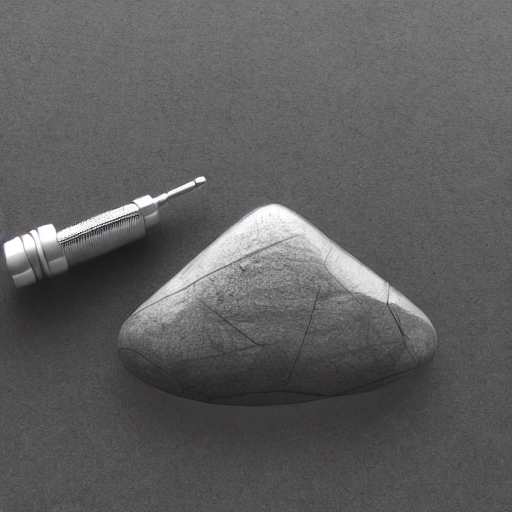

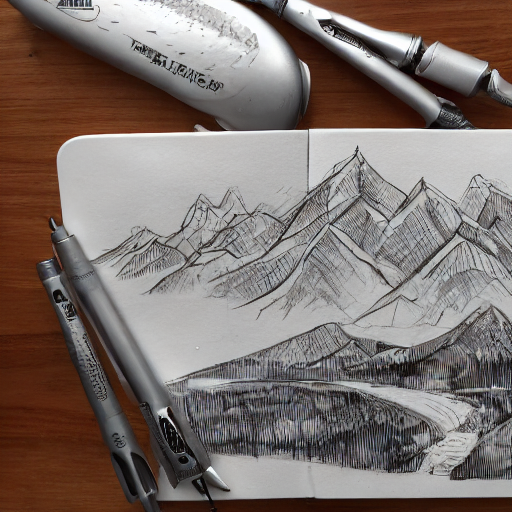

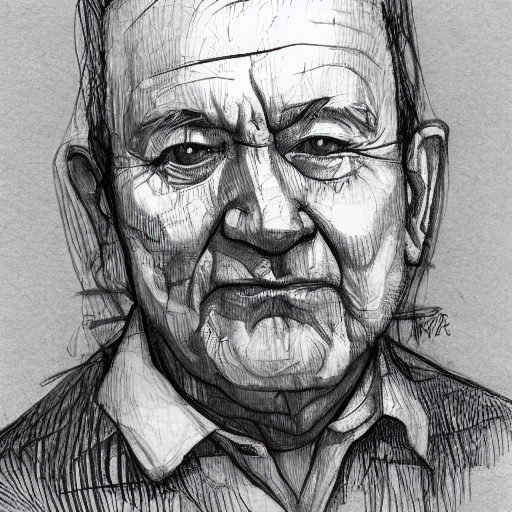

In [3]:
# Sketch Projesi – LoRA Inference & Test Notebook
# Bu notebook: egitilmis LoRA'lari kontrollu sekilde test etmek icindir
# Ortam: Google Colab (GPU)

# =============================================================
# 1️⃣ ORTAM KURULUMU
# =============================================================

!pip install -q diffusers==0.25.0 transformers accelerate safetensors torch torchvision

import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
import os

# =============================================================
# 2️⃣ GOOGLE DRIVE BAGLANTISI
# =============================================================

from google.colab import drive
drive.mount('/content/drive')

# =============================================================
# 3️⃣ BASE MODEL YUKLEME (EGITIMDE KULLANILAN ILE AYNI)
# =============================================================

base_model_path = "/content/sd-v1-5-pruned-noema-fp16.safetensors"

pipe = StableDiffusionPipeline.from_single_file(
    base_model_path,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

pipe.enable_xformers_memory_efficient_attention()
pipe.enable_attention_slicing()

# =============================================================
# 4️⃣ LORA YUKLEME FONKSIYONU
# =============================================================

LORA_DIR = "/content/drive/MyDrive/Loras/sketch_projesi/output"

def load_lora(lora_name, weight=1.0):
    pipe.load_lora_weights(LORA_DIR, weight_name=lora_name)
    pipe.fuse_lora(lora_scale=weight)

# =============================================================
# 5️⃣ TEST AYARLARI (SABIT)
# =============================================================

GEN_SETTINGS = {
    "num_inference_steps": 25,
    "guidance_scale": 6.5,
    "height": 512,
    "width": 512,
    "generator": torch.manual_seed(123456)
}

TEST_PROMPTS = {
    "object": "sketchai_style, a simple stone on the ground",
    "landscape": "sketchai_style, a wide mountain landscape",
    "human": "sketchai_style, a portrait of an old man"
}


NEGATIVE_PROMPT = "photorealistic, color, painting, blurry, low quality"


# =============================================================
# 7️⃣ TEK LORA TEST FONKSIYONU
# =============================================================


def test_lora(lora_file, weight=1.0):
    load_lora(lora_file, weight)

    results = {}

    for key, prompt in TEST_PROMPTS.items():
        image = pipe(
            prompt=prompt,
            negative_prompt=NEGATIVE_PROMPT,
            **GEN_SETTINGS
        ).images[0]

        results[key] = image

    return results



# =============================================================
# 8️⃣ ORNEK CALISTIRMA
# =============================================================


# Degistirerek test et:
# sketch_projesi-04.safetensors
# sketch_projesi-05.safetensors
# sketch_projesi-06.safetensors


results = test_lora("sketch_projesi-05.safetensors", weight=0.9)


for k, img in results.items():
  display(img)

##image to image


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/13 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


INPUT


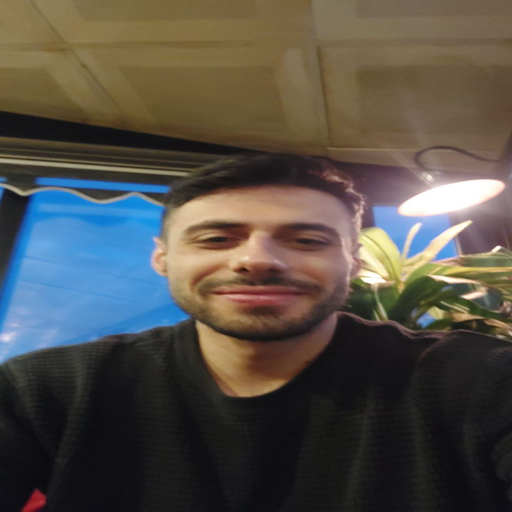

OUTPUT


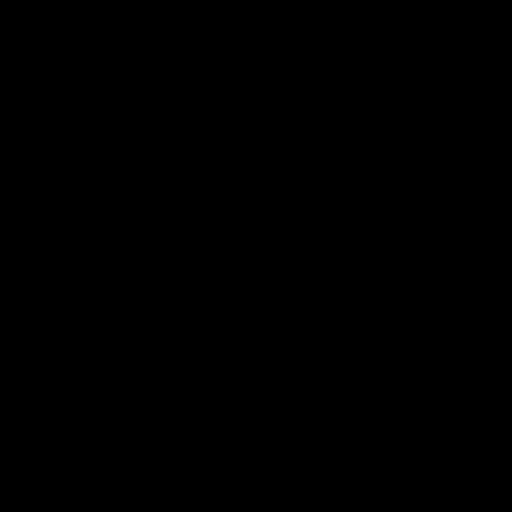

In [4]:
# Sketch Projesi – Image-to-Image Inference Notebook
# Amaç: Kullanıcıdan gelen bir görseli, egitilmis Sketch LoRA ile eskiz stile donusturmek
# Ortam: Google Colab (GPU)

# =============================================================
# 1️⃣ KURULUM
# =============================================================

!pip install -q diffusers==0.25.0 transformers accelerate safetensors torch torchvision pillow

import torch
from diffusers import StableDiffusionImg2ImgPipeline
from PIL import Image
import os

# =============================================================
# 2️⃣ GOOGLE DRIVE BAGLANTISI
# =============================================================

from google.colab import drive
drive.mount('/content/drive')

# =============================================================
# 3️⃣ BASE MODEL (EGITIMDE KULLANILAN ILE AYNI)
# =============================================================

base_model_path = "/content/sd-v1-5-pruned-noema-fp16.safetensors"

pipe = StableDiffusionImg2ImgPipeline.from_single_file(
    base_model_path,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

pipe.enable_xformers_memory_efficient_attention()
pipe.enable_attention_slicing()

# =============================================================
# 4️⃣ LORA YUKLEME
# =============================================================

LORA_DIR = "/content/drive/MyDrive/Loras/sketch_projesi/output"

# Not: Colab'ta arka arkaya test icin once once fuse yapilir

def load_lora(lora_file, weight=0.9):
    pipe.load_lora_weights(LORA_DIR, weight_name=lora_file)
    pipe.fuse_lora(lora_scale=weight)

# =============================================================
# 5️⃣ INPUT GORSEL YUKLEME
# =============================================================

# Kendi test etmek istedigin gorseli buraya koy
INPUT_IMAGE_PATH = "/content/drive/MyDrive/best/1744660723205.jpg"  # degistir

init_image = Image.open(INPUT_IMAGE_PATH).convert("RGB")
init_image = init_image.resize((512, 512))

# =============================================================
# 6️⃣ IMAGE-TO-IMAGE AYARLARI
# =============================================================

IMG2IMG_SETTINGS = {
    "num_inference_steps": 25,
    "guidance_scale": 6.5,
    "strength": 0.55,   # EN KRITIK PARAMETRE
    "generator": torch.manual_seed(123456)
}

PROMPT = "sketchai_style, hand-drawn pencil sketch, clean lineart"
NEGATIVE_PROMPT = "photorealistic, color, painting, blurry, low quality"

# =============================================================
# 7️⃣ IMAGE-TO-IMAGE CALISTIRMA
# =============================================================

load_lora("sketch_projesi-05.safetensors", weight=0.9)

result = pipe(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    image=init_image,
    **IMG2IMG_SETTINGS
).images[0]

# =============================================================
# 8️⃣ SONUCLARI GOSTER
# =============================================================

print("INPUT")
display(init_image)
print("OUTPUT")
display(result)


#i2i

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/25 [00:00<?, ?it/s]

INPUT


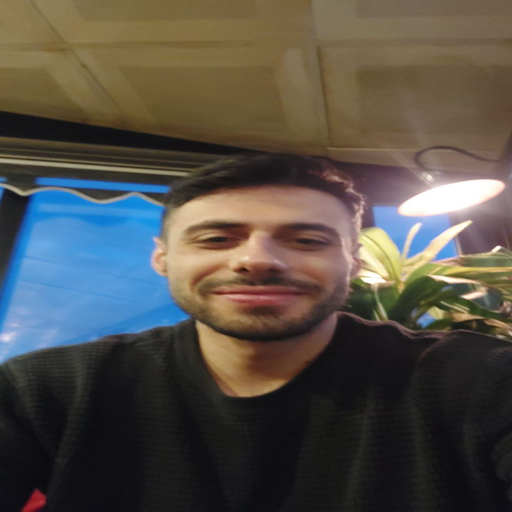

OUTPUT


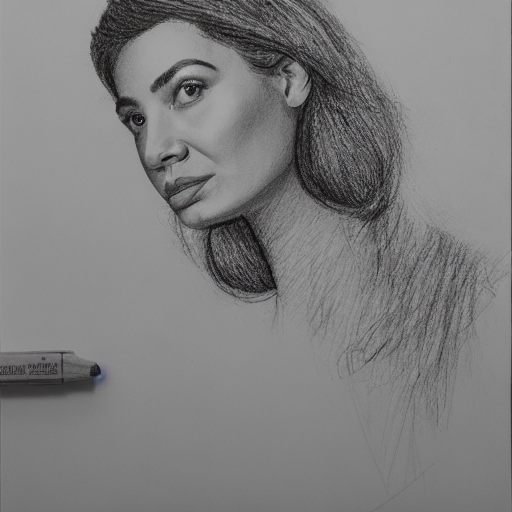

In [6]:
# =============================================================
# Sketch Projesi – Image-to-Image Inference (FIXED)
# =============================================================

!pip install -q diffusers==0.25.0 transformers accelerate safetensors torch torchvision pillow xformers

import torch
from diffusers import StableDiffusionPipeline
from PIL import Image
from google.colab import drive
import os

# =============================================================
# 1️⃣ GOOGLE DRIVE
# =============================================================

drive.mount("/content/drive")

# =============================================================
# 2️⃣ BASE MODEL (EGITIMDE KULLANILAN ILE AYNI)
# =============================================================

base_model_path = "/content/sd-v1-5-pruned-noema-fp16.safetensors"

pipe = StableDiffusionPipeline.from_single_file(
    base_model_path,
    torch_dtype=torch.float16,
    safety_checker=None
).to("cuda")

pipe.enable_xformers_memory_efficient_attention()
pipe.enable_attention_slicing()

# scheduler reset (siyah frame fix)
pipe.scheduler = pipe.scheduler.from_config(pipe.scheduler.config)

# =============================================================
# 3️⃣ LORA YUKLEME (FUSE YOK)
# =============================================================

LORA_DIR = "/content/drive/MyDrive/Loras/sketch_projesi/output"

def load_lora(lora_file, weight=0.9):
    pipe.load_lora_weights(LORA_DIR, weight_name=lora_file)
    pipe.set_adapters(["default"], adapter_weights=[weight])

# =============================================================
# 4️⃣ INPUT IMAGE
# =============================================================

INPUT_IMAGE_PATH = "/content/drive/MyDrive/best/1744660723205.jpg"  # BURAYI DEGISTIR

init_image = Image.open(INPUT_IMAGE_PATH).convert("RGB")
init_image = init_image.resize((512, 512))

# =============================================================
# 5️⃣ PROMPT & AYARLAR
# =============================================================

PROMPT = (
    "sketchai_style, hand-drawn pencil sketch, clean lineart, "
    "preserve original composition, same pose, same facial structure"
)

NEGATIVE_PROMPT = (
    "anime, manga, illustration, fantasy character, "
    "photorealistic, color, painting, blurry, low quality"
)


load_lora("sketch_projesi-05.safetensors", weight=0.9)

generator = torch.manual_seed(123456)

# =============================================================
# 6️⃣ IMAGE-TO-IMAGE RUN
# =============================================================

result = pipe(
    prompt=PROMPT,
    negative_prompt=NEGATIVE_PROMPT,
    image=init_image,
    strength=0.30,              # 0.45 – 0.6 arasi idealdir
    num_inference_steps=25,
    guidance_scale=6.5,
    generator=generator
).images[0]

# =============================================================
# 7️⃣ OUTPUT
# =============================================================

print("INPUT")
display(init_image)

print("OUTPUT")
display(result)
